# WiDS Datathon 2021

Target : Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

by : Sebastián Uribe Ocampo

## Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_style("whitegrid")
#import plotly.express as px
# pd.options.plotting.backend = "plotly"
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 100)

In [3]:
from scipy.stats import chi2_contingency

# UTILS

In [4]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# LOAD DATA

In [6]:
diabetes = pd.read_csv("../data/raw/TrainingWiDS2021.csv")

In [7]:
diabetes.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,...,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,0,NaN,NaN,NaN,88.0,48.0,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,1,8.0,62.0,30.0,48.0,42.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,0,NaN,NaN,NaN,99.0,57.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [8]:
print("Train File Size   : ",diabetes.shape)
print("# encounter_id    : ",diabetes.encounter_id.nunique())
print("# hospital_id     : ",diabetes.hospital_id.nunique())

Train File Size   :  (130157, 181)
# encounter_id    :  130157
# hospital_id     :  204


In [9]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 181 entries, Unnamed: 0 to diabetes_mellitus
dtypes: float64(157), int64(18), object(6)
memory usage: 179.7+ MB


In [11]:
data_info = pd.read_csv("../docs/DataDictionaryWiDS2021.csv")
data_info["Category"].value_counts()

labs                  60
vitals                52
APACHE covariate      28
labs blood gas        16
demographic           15
APACHE comorbidity     7
identifier             2
Target Variable        1
Name: Category, dtype: int64

In [12]:
data_info["Data Type"].value_counts()

numeric    150
binary      15
string      10
integer      6
Name: Data Type, dtype: int64

According to DataDictionaryWiDS2021.csv file there are 6 different kind of sources of information. .. Lets analyze each of them 

In [13]:
data_info.groupby(["Category"])["Data Type"].value_counts()

Category            Data Type
APACHE comorbidity  binary        7
APACHE covariate    numeric      18
                    binary        5
                    integer       3
                    string        2
Target Variable     binary        1
demographic         string        8
                    numeric       4
                    binary        2
                    integer       1
identifier          integer       2
labs                numeric      60
labs blood gas      numeric      16
vitals              numeric      52
Name: Data Type, dtype: int64

# EDA Train

## identifier hospital_id

In [14]:
diabetes["hospital_id"].value_counts()

118    4306
19     3885
188    3075
86     2962
7      2944
       ... 
23        7
93        6
95        6
130       2
25        2
Name: hospital_id, Length: 204, dtype: int64

In [15]:
diabetes["hospital_id"].value_counts(1).head()

118    0.033083
19     0.029849
188    0.023625
86     0.022757
7      0.022619
Name: hospital_id, dtype: float64

In [16]:
diabetes.groupby(["hospital_id"]).agg(n_encounter   =("encounter_id","count"),
                                      total_diabetes =("diabetes_mellitus","sum"),
                                      diabetes_rate =("diabetes_mellitus","mean")
                                      ).query('diabetes_rate > 0.3 & n_encounter >50')\
                                       .sort_values(["diabetes_rate"],ascending=False)

,n_encounter,total_diabetes,diabetes_rate
hospital_id,,,
51,110,41,0.372727
37,734,266,0.362398
128,1029,352,0.342080
8,388,128,0.329897
200,367,119,0.324251
58,1344,435,0.323661
16,267,84,0.314607
94,176,55,0.312500
88,61,19,0.311475


IDEA : 
* hospital_id might have information about location, there could be places where people have a predesposition for diabetes, but this information might be only worth using if in the test set we can relate the information. 

## demographic

In [17]:
data_info[data_info["Category"]=="demographic"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
15,demographic,readmission_status,None,binary,Whether the current unit stay is the second (o...,0
11,demographic,icu_id,None,integer,A unique identifier for the unit to which the ...,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
7,demographic,height,centimetres,numeric,The height of the person on unit admission,180
14,demographic,pre_icu_los_days,Days,numeric,The length of stay of the patient between hosp...,3.5
16,demographic,weight,kilograms,numeric,The weight (body mass) of the person on unit a...,80
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
5,demographic,ethnicity,None,string,The common national or cultural tradition whic...,Caucasian
6,demographic,gender,None,string,The genotypical sex of the patient,F


In [18]:
data_info[data_info["Variable Name"]=="icu_id"]["Description"][11]

'A unique identifier for the unit to which the patient was admitted'

In [19]:
demographic_features = data_info[data_info["Category"]=="demographic"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()
demographic_features.remove("icu_admit_type")

In [20]:
diabetes[demographic_features].head()

,elective_surgery,readmission_status,icu_id,age,height,pre_icu_los_days,weight,bmi,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,0,0,92,68.0,180.3,0.541667,73.9,22.732803,Caucasian,M,Floor,Floor,admit,CTICU
1,0,0,90,77.0,160.0,0.927778,70.2,27.421875,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,0,0,93,25.0,172.7,0.000694,95.3,31.952749,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,1,0,92,81.0,165.1,0.000694,61.7,22.635548,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,0,0,91,19.0,188.0,0.073611,NaN,NaN,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU


In [21]:
diabetes[demographic_features].isnull().mean().sort_values(ascending=False)

hospital_admit_source    0.255061
age                      0.038323
bmi                      0.034497
weight                   0.026606
height                   0.015958
ethnicity                0.012193
icu_admit_source         0.001844
gender                   0.000507
icu_type                 0.000000
icu_stay_type            0.000000
pre_icu_los_days         0.000000
icu_id                   0.000000
readmission_status       0.000000
elective_surgery         0.000000
dtype: float64

In [22]:
diabetes[demographic_features].select_dtypes("O").nunique()

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64

In [23]:
diabetes.pivot_table(values="encounter_id",
                    index="gender",
                     columns="ethnicity",
                     aggfunc='count',
                     fill_value=None,
                     margins=True
                    )

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,All
gender,,,,,,,
F,6747,1048,45704,2339,450,2632,58920
M,7159,1150,54523,2709,465,3617,69623
All,13906,2198,100227,5048,915,6249,128543


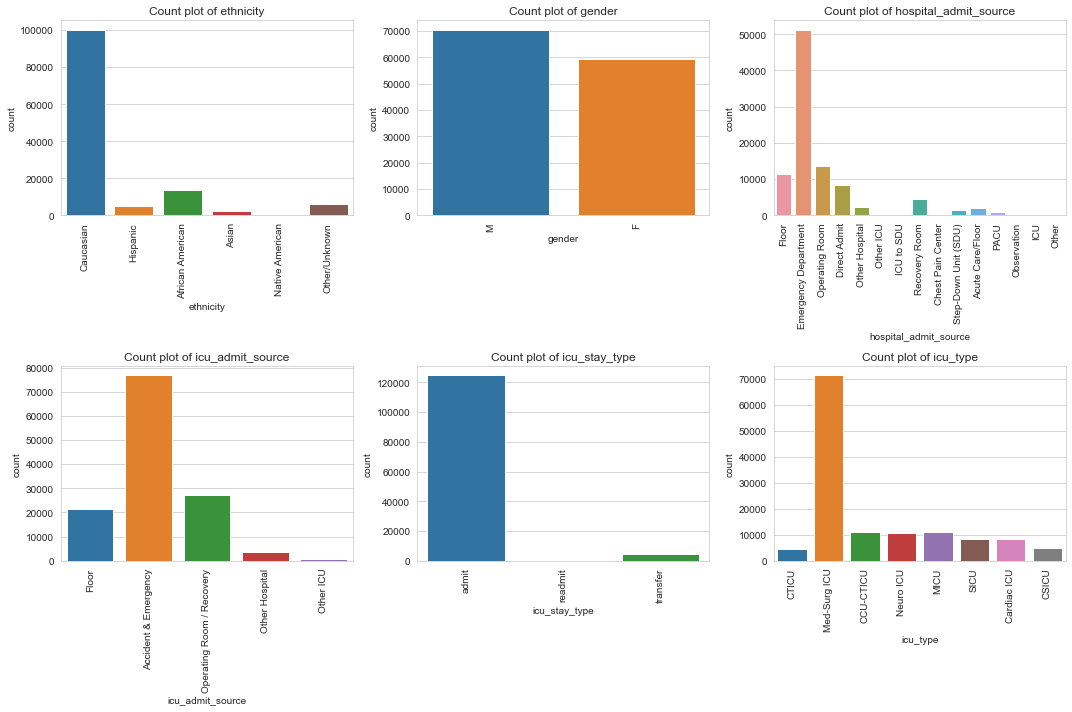

In [24]:
plt.figure(figsize=(15,10))
vars_to_look = diabetes[demographic_features].select_dtypes("O").columns
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    plt.xticks(rotation = 90)
    sns.countplot(diabetes[var])
    plt.title("Count plot of " + var)
plt.tight_layout()

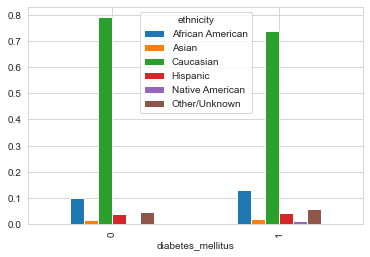

In [25]:
diabetes.groupby(["diabetes_mellitus"])["ethnicity"].value_counts(1).unstack().plot(kind="bar");

In [26]:
diabetes.pivot_table(values="diabetes_mellitus",
                     index="gender",
                     columns="ethnicity",
                     aggfunc='mean',
                     fill_value=None,
#                     margins=True
                    ).style.highlight_max(color='lightgreen')

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
gender,,,,,,
F,0.287239,0.228053,0.198517,0.237708,0.315556,0.262158
M,0.239698,0.260000,0.211470,0.253599,0.326882,0.249931


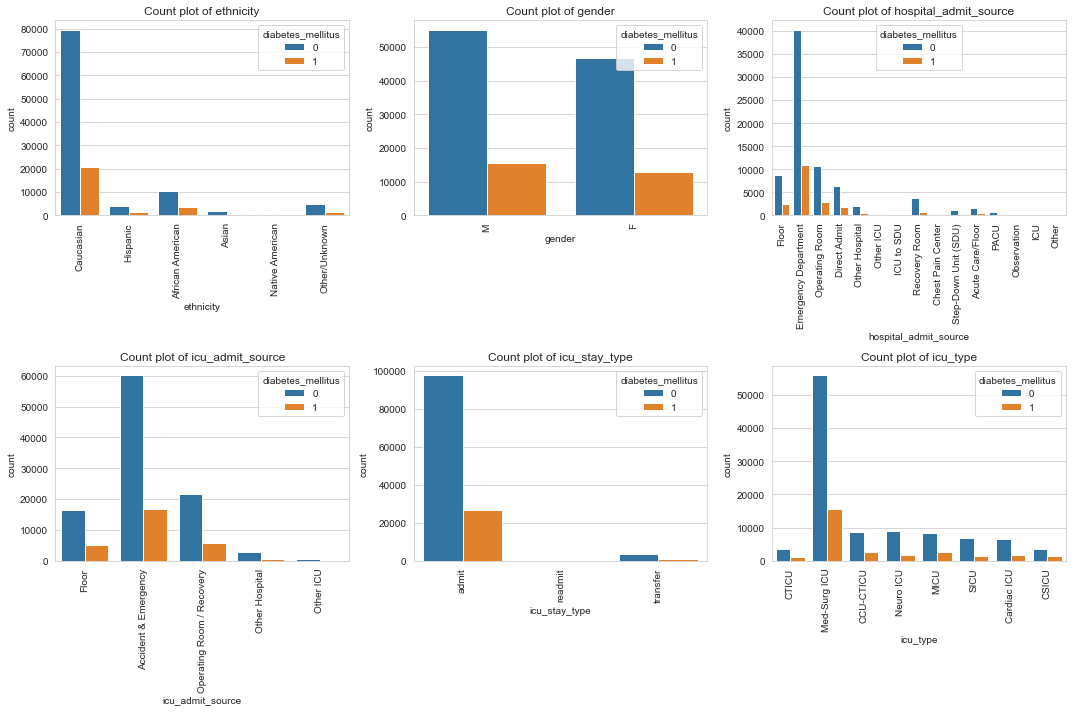

In [27]:
plt.figure(figsize=(15,10))
vars_to_look = diabetes[demographic_features].select_dtypes("O").columns
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    plt.xticks(rotation = 90)
    sns.countplot(x=var, data=diabetes,hue="diabetes_mellitus")
    plt.title("Count plot of " + var)
plt.tight_layout()

In [28]:
diabetes[demographic_features].select_dtypes("O")

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,Caucasian,M,Floor,Floor,admit,CTICU
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU
...,...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130153,Caucasian,F,Direct Admit,Accident & Emergency,admit,MICU
130154,African American,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130155,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU


In [29]:
diabetes[demographic_features].describe()

,elective_surgery,readmission_status,icu_id,age,height,pre_icu_los_days,weight,bmi
count,130157.000000,130157.0,130157.000000,125169.000000,128080.000000,130157.000000,126694.000000,125667.000000
mean,0.189840,0.0,662.428344,61.995103,169.607219,0.839933,83.791104,29.110260
std,0.392176,0.0,304.259843,16.822880,10.833085,2.485337,24.963063,8.262776
min,0.000000,0.0,82.000000,0.000000,137.200000,-0.250000,38.600000,14.844926
25%,0.000000,0.0,427.000000,52.000000,162.500000,0.045833,66.500000,23.598006
50%,0.000000,0.0,653.000000,64.000000,170.100000,0.155556,80.000000,27.564749
75%,0.000000,0.0,969.000000,75.000000,177.800000,0.423611,96.800000,32.803127
max,1.000000,0.0,1111.000000,89.000000,195.590000,175.627778,186.000000,67.814990


In [30]:
diabetes.groupby(["diabetes_mellitus"])[["pre_icu_los_days"]].describe()

pre_icu_los_days                                          \
                             count      mean       std       min       25%   
diabetes_mellitus                                                            
0                         102006.0  0.811025  2.417159 -0.250000  0.044444   
1                          28151.0  0.944681  2.715564 -0.211806  0.050000   

                                                   
                        50%       75%         max  
diabetes_mellitus                                  
0                  0.152778  0.412500  175.627778  
1                  0.168056  0.476042  159.090972

In [31]:
diabetes["readmission_status"].value_counts()

0    130157
Name: readmission_status, dtype: int64

In [32]:
diabetes.groupby(["diabetes_mellitus"])[["age","bmi","height","weight"]].mean()

,age,bmi,height,weight
diabetes_mellitus,,,,
0,61.272026,28.375530,169.631770,81.750636
1,64.564257,31.765574,169.518772,91.177235


In [33]:
diabetes.groupby(["ethnicity","diabetes_mellitus"])[["age","bmi","height","weight"]].mean()

age        bmi      height  \
ethnicity        diabetes_mellitus                                     
African American 0                  54.578858  29.405794  170.853703   
                 1                  60.436238  32.127416  170.018133   
Asian            0                  59.972414  25.238583  162.486889   
                 1                  66.744681  26.060955  162.301600   
Caucasian        0                  62.716619  28.309793  169.940517   
                 1                  65.602809  32.060064  170.137403   
Hispanic         0                  58.634173  28.266986  165.521073   
                 1                  63.257048  29.685886  165.534566   
Native American  0                  49.748777  29.979039  168.415922   
                 1                  56.346939  33.202034  167.984296   
Other/Unknown    0                  56.493515  28.150031  167.413768   
                 1                  62.520408  30.282623  166.022567   

                                       weight  
ethnicity        diabetes_mellitus             
African American 0                  85.611139  
                 1                  92.437716  
Asian            0                  66.762939  
                 1                  68.713988  
Caucasian        0                  81.869501  
                 1                  92.651057  
Hispanic         0                  77.532792  
                 1                  81.534276  
Native American  0                  85.248013  
                 1                  93.366471  
Other/Unknown    0                  78.983490  
                 1                  83.424892

Observations :
As expected, looks like  heavier people are prone to diabetes

* hospital_admit_source 25% is missing
* looks like there are babys in the dataset...
* ethnicity looks important and it is stratify across all the categories. 
* icu_id is irrelevant
* readmission_status is totally NULL

## APACHE comorbidity

In [34]:
data_info[data_info["Category"]=="APACHE comorbidity"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
173,APACHE comorbidity,aids,None,binary,Whether the patient has a definitive diagnosis...,1
174,APACHE comorbidity,cirrhosis,None,binary,Whether the patient has a history of heavy alc...,1
175,APACHE comorbidity,hepatic_failure,None,binary,Whether the patient has cirrhosis and addition...,1
176,APACHE comorbidity,immunosuppression,None,binary,Whether the patient has their immune system su...,1
177,APACHE comorbidity,leukemia,None,binary,Whether the patient has been diagnosed with ac...,1
178,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
179,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1


In [35]:
apache_comorbidity_features = data_info[data_info["Category"]=="APACHE comorbidity"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()

In [36]:
diabetes[apache_comorbidity_features].isnull().sum()

aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
dtype: int64

In [37]:
diabetes[apache_comorbidity_features].apply(lambda x:x.value_counts())

,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,130023,128064,128387,126816,129206,129612,127443
1,134,2093,1770,3341,951,545,2714


In [38]:
def chi2_contingency_test(df,target,variable):
    print(pd.crosstab(df[target],df[variable]))
    g, p, dof, expctd = chi2_contingency(pd.crosstab(df[target],df[variable]))
    print(f"p-value of Chi-square test for {target} vs. {variable} =", p)

In [39]:
chi2_contingency_test(diabetes,"diabetes_mellitus","aids")

aids                    0    1
diabetes_mellitus             
0                  101883  123
1                   28140   11
p-value of Chi-square test for diabetes_mellitus vs. aids = 0.00024248126608415052


In [40]:
chi2_contingency_test(diabetes,"diabetes_mellitus","cirrhosis")

cirrhosis               0     1
diabetes_mellitus              
0                  100468  1538
1                   27596   555
p-value of Chi-square test for diabetes_mellitus vs. cirrhosis = 5.050784627645201e-08


In [41]:
chi2_contingency_test(diabetes,"diabetes_mellitus","hepatic_failure")

hepatic_failure         0     1
diabetes_mellitus              
0                  100678  1328
1                   27709   442
p-value of Chi-square test for diabetes_mellitus vs. hepatic_failure = 0.0006478012566495153


In [42]:
chi2_contingency_test(diabetes,"diabetes_mellitus","immunosuppression")

immunosuppression      0     1
diabetes_mellitus             
0                  99362  2644
1                  27454   697
p-value of Chi-square test for diabetes_mellitus vs. immunosuppression = 0.2851241513436893


In [43]:
chi2_contingency_test(diabetes,"diabetes_mellitus","leukemia")

leukemia                0    1
diabetes_mellitus             
0                  101277  729
1                   27929  222
p-value of Chi-square test for diabetes_mellitus vs. leukemia = 0.21128422465445623


In [44]:
chi2_contingency_test(diabetes,"diabetes_mellitus","lymphoma")

lymphoma                0    1
diabetes_mellitus             
0                  101578  428
1                   28034  117
p-value of Chi-square test for diabetes_mellitus vs. lymphoma = 0.968787775041885


In [45]:
chi2_contingency_test(diabetes,"diabetes_mellitus","solid_tumor_with_metastasis")

solid_tumor_with_metastasis      0     1
diabetes_mellitus                       
0                            99778  2228
1                            27665   486
p-value of Chi-square test for diabetes_mellitus vs. solid_tumor_with_metastasis = 2.188993359520709e-06


Observations : 

* cirrhosis and hepatic_failure both features sometimes related to drinking alcohol . Commonly Type 2 diabetes is associated with a large number of liver disorders. 
* Patients with type 2 diabetes have a 20 per cent increased risk of developing blood cancers [URL](https://www.sciencedaily.com/releases/2012/06/120605121658.htm#:~:text=developing%20blood%20cancers.-,Patients%20with%20type%202%20diabetes%20have%20a%2020%20percent%20increased,researchers%20at%20The%20Miriam%20Hospital.) but the dataset provided does not present this behavior , might look for confounding variables

## APACHE covariate

In [46]:
data_info[data_info["Category"]=="APACHE covariate"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
20,APACHE covariate,apache_post_operative,None,binary,The APACHE operative status; 1 for post-operat...,1
21,APACHE covariate,arf_apache,None,binary,Whether the patient had acute renal failure du...,0
28,APACHE covariate,gcs_unable_apache,None,binary,Whether the Glasgow Coma Scale was unable to b...,1
33,APACHE covariate,intubated_apache,None,binary,Whether the patient was intubated at the time ...,0
43,APACHE covariate,ventilated_apache,None,binary,Whether the patient was invasively ventilated ...,1
26,APACHE covariate,gcs_eyes_apache,None,integer,The eye opening component of the Glasgow Coma ...,4
27,APACHE covariate,gcs_motor_apache,None,integer,The motor component of the Glasgow Coma Scale ...,6
29,APACHE covariate,gcs_verbal_apache,None,integer,The verbal component of the Glasgow Coma Scale...,5
17,APACHE covariate,albumin_apache,g/L,numeric,The albumin concentration measured during the ...,30
22,APACHE covariate,bilirubin_apache,micromol/L,numeric,The bilirubin concentration measured during th...,20


In [47]:
apache_covariate_features =  data_info[data_info["Category"]=="APACHE covariate"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()


In [48]:
diabetes[apache_covariate_features].isnull().mean().sort_values(ascending=False)

paco2_for_ph_apache      0.766152
ph_apache                0.766152
fio2_apache              0.766152
paco2_apache             0.766152
pao2_apache              0.766152
bilirubin_apache         0.634311
albumin_apache           0.600529
urineoutput_apache       0.485314
wbc_apache               0.226457
hematocrit_apache        0.205582
bun_apache               0.195233
creatinine_apache        0.191169
sodium_apache            0.188380
glucose_apache           0.112910
temp_apache              0.050793
gcs_eyes_apache          0.016826
gcs_motor_apache         0.016826
gcs_verbal_apache        0.016826
apache_2_diagnosis       0.012946
apache_3j_diagnosis      0.006646
resprate_apache          0.006208
gcs_unable_apache        0.005447
map_apache               0.003227
heart_rate_apache        0.002374
ventilated_apache        0.000000
intubated_apache         0.000000
arf_apache               0.000000
apache_post_operative    0.000000
dtype: float64

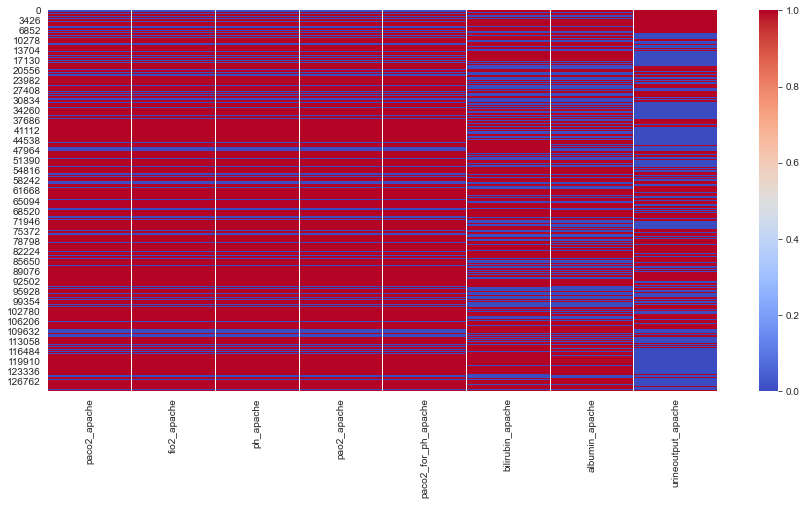

In [49]:
plt.figure(figsize=(15,7))
sns.heatmap(diabetes[['paco2_apache', 'fio2_apache', 'ph_apache', 'pao2_apache',
                      'paco2_for_ph_apache', 'bilirubin_apache', 'albumin_apache',
                      'urineoutput_apache']].isnull(),
            cmap="coolwarm");

In [50]:
diabetes[apache_covariate_features].iloc[:,:5].apply(lambda x:x.value_counts())

,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache
0.0,103200,126513,127967,109771,87149
1.0,26957,3644,1481,20386,43008


In [51]:
chi2_contingency_test(diabetes,"diabetes_mellitus","apache_post_operative")

apache_post_operative      0      1
diabetes_mellitus                  
0                      80624  21382
1                      22576   5575
p-value of Chi-square test for diabetes_mellitus vs. apache_post_operative = 2.2883967112267962e-05


In [52]:
chi2_contingency_test(diabetes,"diabetes_mellitus","arf_apache")

arf_apache              0     1
diabetes_mellitus              
0                  100109  1897
1                   26404  1747
p-value of Chi-square test for diabetes_mellitus vs. arf_apache = 0.0


In [53]:
chi2_contingency_test(diabetes,"diabetes_mellitus","gcs_unable_apache")

gcs_unable_apache     0.0   1.0
diabetes_mellitus              
0                  100125  1232
1                   27842   249
p-value of Chi-square test for diabetes_mellitus vs. gcs_unable_apache = 5.1705418679112256e-06


In [54]:
chi2_contingency_test(diabetes,"diabetes_mellitus","ventilated_apache")

ventilated_apache      0      1
diabetes_mellitus              
0                  68600  33406
1                  18549   9602
p-value of Chi-square test for diabetes_mellitus vs. ventilated_apache = 1.810732193575899e-05


In [55]:
diabetes[["gcs_eyes_apache","gcs_motor_apache","gcs_verbal_apache"]].describe()

,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache
count,127967.000000,127967.000000,127967.000000
mean,3.488290,5.484828,4.030203
std,0.939831,1.271039,1.538528
min,1.000000,1.000000,1.000000
25%,3.000000,6.000000,4.000000
50%,4.000000,6.000000,5.000000
75%,4.000000,6.000000,5.000000
max,4.000000,6.000000,5.000000


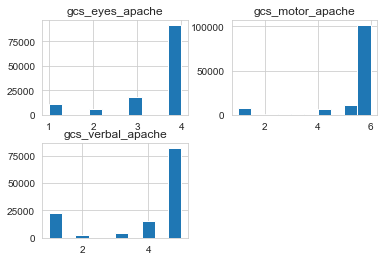

In [56]:
diabetes[["gcs_eyes_apache","gcs_motor_apache","gcs_verbal_apache"]].hist();

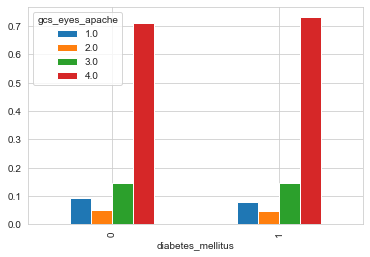

In [57]:
diabetes.groupby(["diabetes_mellitus"])["gcs_eyes_apache"].value_counts(1).unstack().plot(kind="bar");

In [58]:
chi2_contingency_test(diabetes,"diabetes_mellitus","gcs_eyes_apache")

gcs_eyes_apache     1.0   2.0    3.0    4.0
diabetes_mellitus                          
0                  9266  4995  14630  71234
1                  2146  1297   4032  20367
p-value of Chi-square test for diabetes_mellitus vs. gcs_eyes_apache = 2.465822754482135e-16


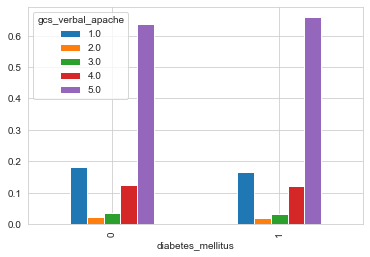

In [59]:
diabetes.groupby(["diabetes_mellitus"])["gcs_verbal_apache"].value_counts(1).unstack().plot(kind="bar");

In [60]:
chi2_contingency_test(diabetes,"diabetes_mellitus","gcs_verbal_apache")

gcs_verbal_apache    1.0   2.0   3.0    4.0    5.0
diabetes_mellitus                                 
0                  18218  2182  3477  12367  63881
1                   4600   580   907   3409  18346
p-value of Chi-square test for diabetes_mellitus vs. gcs_verbal_apache = 8.021429865647618e-11


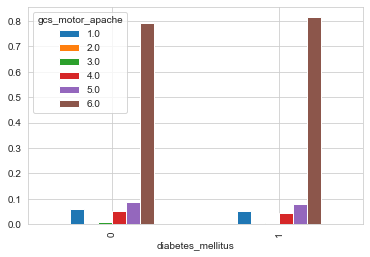

In [61]:
diabetes.groupby(["diabetes_mellitus"])["gcs_motor_apache"].value_counts(1).unstack().plot(kind="bar");

In [62]:
chi2_contingency_test(diabetes,"diabetes_mellitus","gcs_motor_apache")

gcs_motor_apache    1.0  2.0  3.0   4.0   5.0    6.0
diabetes_mellitus                                   
0                  6084  413  662  5244  8588  79134
1                  1465   90  145  1213  2245  22684
p-value of Chi-square test for diabetes_mellitus vs. gcs_motor_apache = 2.216397532687665e-18


In [63]:
diabetes[apache_covariate_features].iloc[:,10:-3].describe()

,bun_apache,creatinine_apache,fio2_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache
count,104746.000000,105275.000000,30437.000000,115461.000000,129848.000000,103399.000000,129737.000000,30437.000000,30437.000000,30437.000000,30437.000000,129349.000000,105638.00000,123546.000000,66990.000000
mean,25.718070,1.481629,0.595735,160.141416,99.854530,32.975817,87.193046,42.161246,42.161246,132.061737,7.352154,25.150603,137.94526,36.420638,1800.803417
std,20.690041,1.543535,0.262922,90.701327,30.759505,6.834576,41.908109,12.267414,12.267414,84.958826,0.098423,15.024730,5.30384,0.857584,1456.551481
min,4.000000,0.300000,0.210000,39.000000,30.000000,16.200000,40.000000,18.000000,18.000000,31.000000,6.960540,4.000000,117.00000,32.100000,0.000000
25%,13.000000,0.710000,0.400000,97.000000,87.000000,28.000000,54.000000,34.500000,34.500000,77.000000,7.301000,11.000000,135.00000,36.200000,799.048800
50%,19.000000,0.970000,0.500000,133.000000,104.000000,33.100000,66.000000,40.000000,40.000000,104.000000,7.360000,27.000000,138.00000,36.500000,1454.976000
75%,31.000000,1.530000,0.850000,195.000000,120.000000,37.900000,124.000000,47.000000,47.000000,156.000000,7.414000,36.000000,141.00000,36.700000,2415.096000
max,127.000000,11.180000,1.000000,598.700000,178.000000,51.400000,200.000000,95.000000,95.000000,498.000000,7.590000,60.000000,158.00000,39.700000,8716.669632


In [64]:
diabetes_describe = diabetes.select_dtypes("number").describe()

In [65]:
# Lets set a dict with limits
limits_dict = {}
for column in diabetes_describe.columns:
    limits_dict[column]={"max":diabetes_describe[column].loc["50%"]+diabetes_describe[column].loc["std"]*2,
                         "min":diabetes_describe[column].loc["min"]}

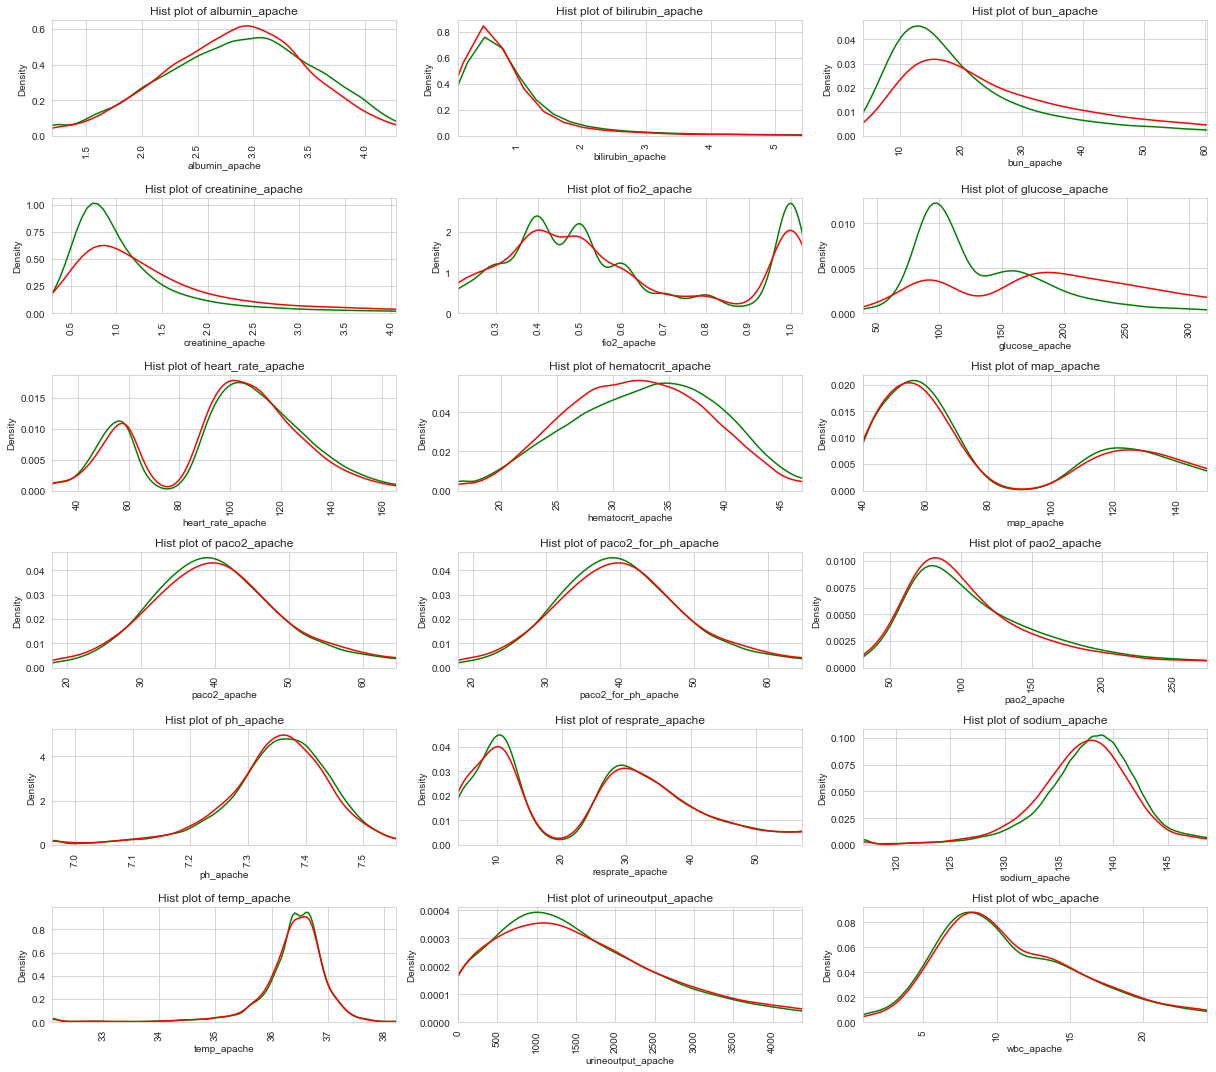

In [66]:
plt.figure(figsize=(17,15))
vars_to_look = apache_covariate_features[8:-2]
for i, var in enumerate(vars_to_look):
    plt.subplot(6,3,i+1)
    plt.xticks(rotation = 90)
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==0],color="green");
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==1],color="red");
    plt.xlim(limits_dict[var]["min"],limits_dict[var]["max"])
    plt.title("Hist plot of " + var)
plt.tight_layout()

In [67]:
diabetes[["apache_2_diagnosis","apache_3j_diagnosis"]].nunique()

apache_2_diagnosis      44
apache_3j_diagnosis    400
dtype: int64

In [68]:
diabetes.groupby(["diabetes_mellitus"])["apache_2_diagnosis"].apply(lambda x:x.value_counts(1).head())

diabetes_mellitus       
0                  113.0    0.123762
                   301.0    0.079477
                   302.0    0.067919
                   122.0    0.048373
                   112.0    0.046672
1                  113.0    0.141732
                   123.0    0.074982
                   302.0    0.074302
                   301.0    0.066858
                   308.0    0.064639
Name: apache_2_diagnosis, dtype: float64

In [69]:
diabetes.groupby(["diabetes_mellitus"])["apache_3j_diagnosis"].apply(lambda x:x.value_counts().head())

diabetes_mellitus         
0                  501.05     4879
                   107.01     4692
                   403.01     4357
                   106.01     4203
                   703.03     3905
1                  702.01     2095
                   104.01     1343
                   1207.01    1333
                   501.05     1301
                   107.01     1289
Name: apache_3j_diagnosis, dtype: int64

Observations :

'paco2_apache', 'fio2_apache', 'ph_apache', 'pao2_apache',
'paco2_for_ph_apache', 'bilirubin_apache', 'albumin_apache',
'urineoutput_apache'
This feautures are mostly missing, but commonly this feautres are useful, might be worth trying to create a model for people with that information, and another one for the rest

"gcs_eyes_apache","gcs_motor_apache","gcs_verbal_apache"

## vitals

In [70]:
data_info[data_info["Category"]=="vitals"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
45,vitals,d1_diasbp_invasive_max,Millimetres of mercury,numeric,The patient's highest diastolic blood pressure...,60
46,vitals,d1_diasbp_invasive_min,Millimetres of mercury,numeric,The patient's lowest diastolic blood pressure ...,60
47,vitals,d1_diasbp_max,Millimetres of mercury,numeric,The patient's highest diastolic blood pressure...,60
48,vitals,d1_diasbp_min,Millimetres of mercury,numeric,The patient's lowest diastolic blood pressure ...,60
49,vitals,d1_diasbp_noninvasive_max,Millimetres of mercury,numeric,The patient's highest diastolic blood pressure...,60
50,vitals,d1_diasbp_noninvasive_min,Millimetres of mercury,numeric,The patient's lowest diastolic blood pressure ...,60
51,vitals,d1_heartrate_max,Beats per minute,numeric,The patient's highest heart rate during the fi...,75
52,vitals,d1_heartrate_min,Beats per minute,numeric,The patient's lowest heart rate during the fir...,75
53,vitals,d1_mbp_invasive_max,Millimetres of mercury,numeric,The patient's highest mean blood pressure duri...,80
54,vitals,d1_mbp_invasive_min,Millimetres of mercury,numeric,The patient's lowest mean blood pressure durin...,80


In [71]:
vitals_features =  data_info[data_info["Category"]=="vitals"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()

In [72]:
diabetes[vitals_features].isnull().mean().sort_values(ascending=False)

h1_diasbp_invasive_max       0.805404
h1_diasbp_invasive_min       0.805404
h1_sysbp_invasive_min        0.805235
h1_sysbp_invasive_max        0.805235
h1_mbp_invasive_min          0.804920
h1_mbp_invasive_max          0.804920
d1_diasbp_invasive_max       0.730410
d1_diasbp_invasive_min       0.730410
d1_sysbp_invasive_max        0.730180
d1_sysbp_invasive_min        0.730180
d1_mbp_invasive_max          0.728874
d1_mbp_invasive_min          0.728874
h1_temp_max                  0.228209
h1_temp_min                  0.228209
h1_mbp_noninvasive_max       0.102161
h1_mbp_noninvasive_min       0.102161
h1_diasbp_noninvasive_min    0.087118
h1_diasbp_noninvasive_max    0.087118
h1_sysbp_noninvasive_min     0.087049
h1_sysbp_noninvasive_max     0.087049
h1_mbp_min                   0.050170
h1_mbp_max                   0.050170
h1_resprate_max              0.049586
h1_resprate_min              0.049586
h1_spo2_min                  0.047957
h1_spo2_max                  0.047957
h1_diasbp_mi

In [73]:
diabetes[vitals_features].describe()

,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min
count,35089.000000,35089.000000,129880.000000,129880.000000,128521.000000,128521.000000,129895.000000,129895.000000,35289.000000,35289.000000,129830.000000,129830.000000,127929.000000,127929.000000,129474.000000,129474.000000,129625.000000,129625.000000,35119.000000,35119.000000,129886.000000,129886.000000,128534.000000,128534.000000,125663.000000,125663.000000,25328.000000,25328.000000,124630.000000,124630.000000,118818.000000,118818.000000,126083.000000,126083.000000,25391.000000,25391.000000,123627.000000,123627.000000,116860.000000,116860.000000,123703.000000,123703.000000,123915.000000,123915.000000,25350.000000,25350.00000,124638.000000,124638.000000,118827.000000,118827.000000,100454.000000,100454.000000
mean,79.261563,46.969706,88.575516,49.862989,88.729344,49.917492,103.296794,70.408530,114.432769,62.211596,104.228522,64.353462,104.183969,64.384111,28.719388,12.690841,99.276104,90.366087,153.285373,93.637604,148.231680,96.669649,148.141690,96.690357,37.301433,36.266697,68.522070,56.659665,75.426093,62.494849,75.901589,62.895176,92.457381,83.789773,94.673728,75.973573,91.287108,78.846218,91.254307,79.087347,22.543528,17.084242,98.096905,95.254521,138.223353,114.76978,133.262584,115.951981,133.059136,116.082237,36.722597,36.613964
std,21.693320,12.736433,20.162800,13.397152,20.155701,13.427746,21.982940,17.141875,49.182744,17.845442,20.910213,15.433092,20.802509,15.458592,10.567866,5.046519,1.722287,10.150349,31.482818,24.596108,25.897117,20.673004,25.936665,20.692563,0.699406,0.767815,16.270976,14.248823,18.539741,16.305348,18.642800,16.386653,21.783253,20.222465,30.463250,19.112166,20.392222,18.844822,20.410918,18.966473,7.441328,5.933458,3.114242,6.468139,28.924396,27.76802,27.452037,26.315817,27.573246,26.422179,0.773744,0.796852
min,37.000000,5.000000,46.000000,13.000000,46.000000,13.000000,58.000000,0.000000,38.000000,2.000000,60.000000,22.000000,60.000000,22.000000,14.000000,0.000000,0.000000,0.000000,71.000000,10.000000,90.000000,41.000000,90.000000,41.030000,35.100000,31.889000,33.000000,19.000000,37.000000,22.000000,37.000000,22.000000,46.000000,36.000000,35.625000,8.000000,49.000000,32.000000,49.000000,32.000000,10.000000,0.000000,0.000000,0.000000,65.000000,31.44000,75.000000,53.000000,75.000000,53.000000,33.400000,32.900000
25%,65.000000,40.000000,75.000000,41.000000,75.000000,41.000000,88.000000,60.000000,89.000000,54.000000,90.000000,54.000000,90.000000,54.000000,22.000000,10.000000,99.000000,89.000000,133.000000,80.000000,130.000000,83.000000,130.000000,83.000000,36.900000,36.100000,58.000000,47.000000,62.000000,51.000000,63.000000,52.000000,77.000000,69.000000,78.000000,64.000000,77.000000,66.000000,77.000000,66.000000,18.000000,13.000000,97.000000,94.000000,119.000000,95.00000,113.000000,97.000000,113.000000,98.000000,36.400000,36.300000
50%,76.000000,46.000000,86.000000,50.000000,87.000000,50.000000,101.000000,70.000000,101.000000,62.000000,102.000000,64.000000,102.000000,64.000000,26.000000,13.000000,100.000000,93.000000,150.000000,92.000000,146.000000,95.000000,146.000000,96.00000

In [74]:
diabetes[(diabetes["h1_resprate_min"]==0)&\
         (diabetes["h1_spo2_max"]==0)&\
         (diabetes["h1_spo2_min"]==0)]

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
62316,62317,204706,43,81.0,49.481875,0,Caucasian,F,167.0,Emergency Department,Accident & Emergency,642,admit,Med-Surg ICU,0.000000,0,138.00,NaN,117.0,106.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,156.0,139.0,NaN,0,118.0,NaN,NaN,NaN,NaN,8.0,NaN,36.8,NaN,0,NaN,NaN,NaN,104.0,27.0,104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
63019,63020,229956,43,55.0,29.098867,0,Caucasian,M,173.0,Emergency Department,Accident & Emergency,642,admit,Med-Surg ICU,0.027083,0,87.09,NaN,302.0,109.02,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,100.0,NaN,0,140.0,NaN,NaN,NaN,NaN,6.0,NaN,36.6,NaN,0,NaN,NaN,NaN,101.0,85.0,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
63091,63092,186158,43,65.0,29.967281,0,Caucasian,F,164.0,NaN,Accident & Emergency,642,admit,Med-Surg ICU,0.054167,0,80.60,NaN,302.0,109.02,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,50.0,NaN,0,56.0,NaN,NaN,NaN,NaN,5.0,NaN,36.0,1.6416,0,NaN,NaN,NaN,60.0,56.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
63143,63144,192041,43,57.0,36.285877,0,Caucasian,M,173.0,NaN,Accident & Emergency,642,admit,Med-Surg ICU,0.038194,0,108.60,NaN,302.0,109.04,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,97.0,NaN,0,119.0,NaN,NaN,NaN,NaN,39.0,NaN,36.2,NaN,0,NaN,NaN,NaN,114.0,47.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
63811,63812,273598,43,NaN,NaN,0,Caucasian,M,NaN,Emergency Department,Accident & Emergency,642,admit,Med-Surg ICU,0.108333,0,72.90,NaN,302.0,109.02,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,93.0,NaN,0,51.0,NaN,NaN,NaN,NaN,31.0,NaN,35.6,898.4736,0,NaN,NaN,NaN,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
64191,64192,251108,43,49.0,NaN,0,Caucasian,F,NaN,NaN,Accident & Emergency,642,admit,Med-Surg ICU,0.024306,0,NaN,NaN,305.0,901.03,0,0,NaN,NaN,NaN,Na

Wall time: 35.2 s


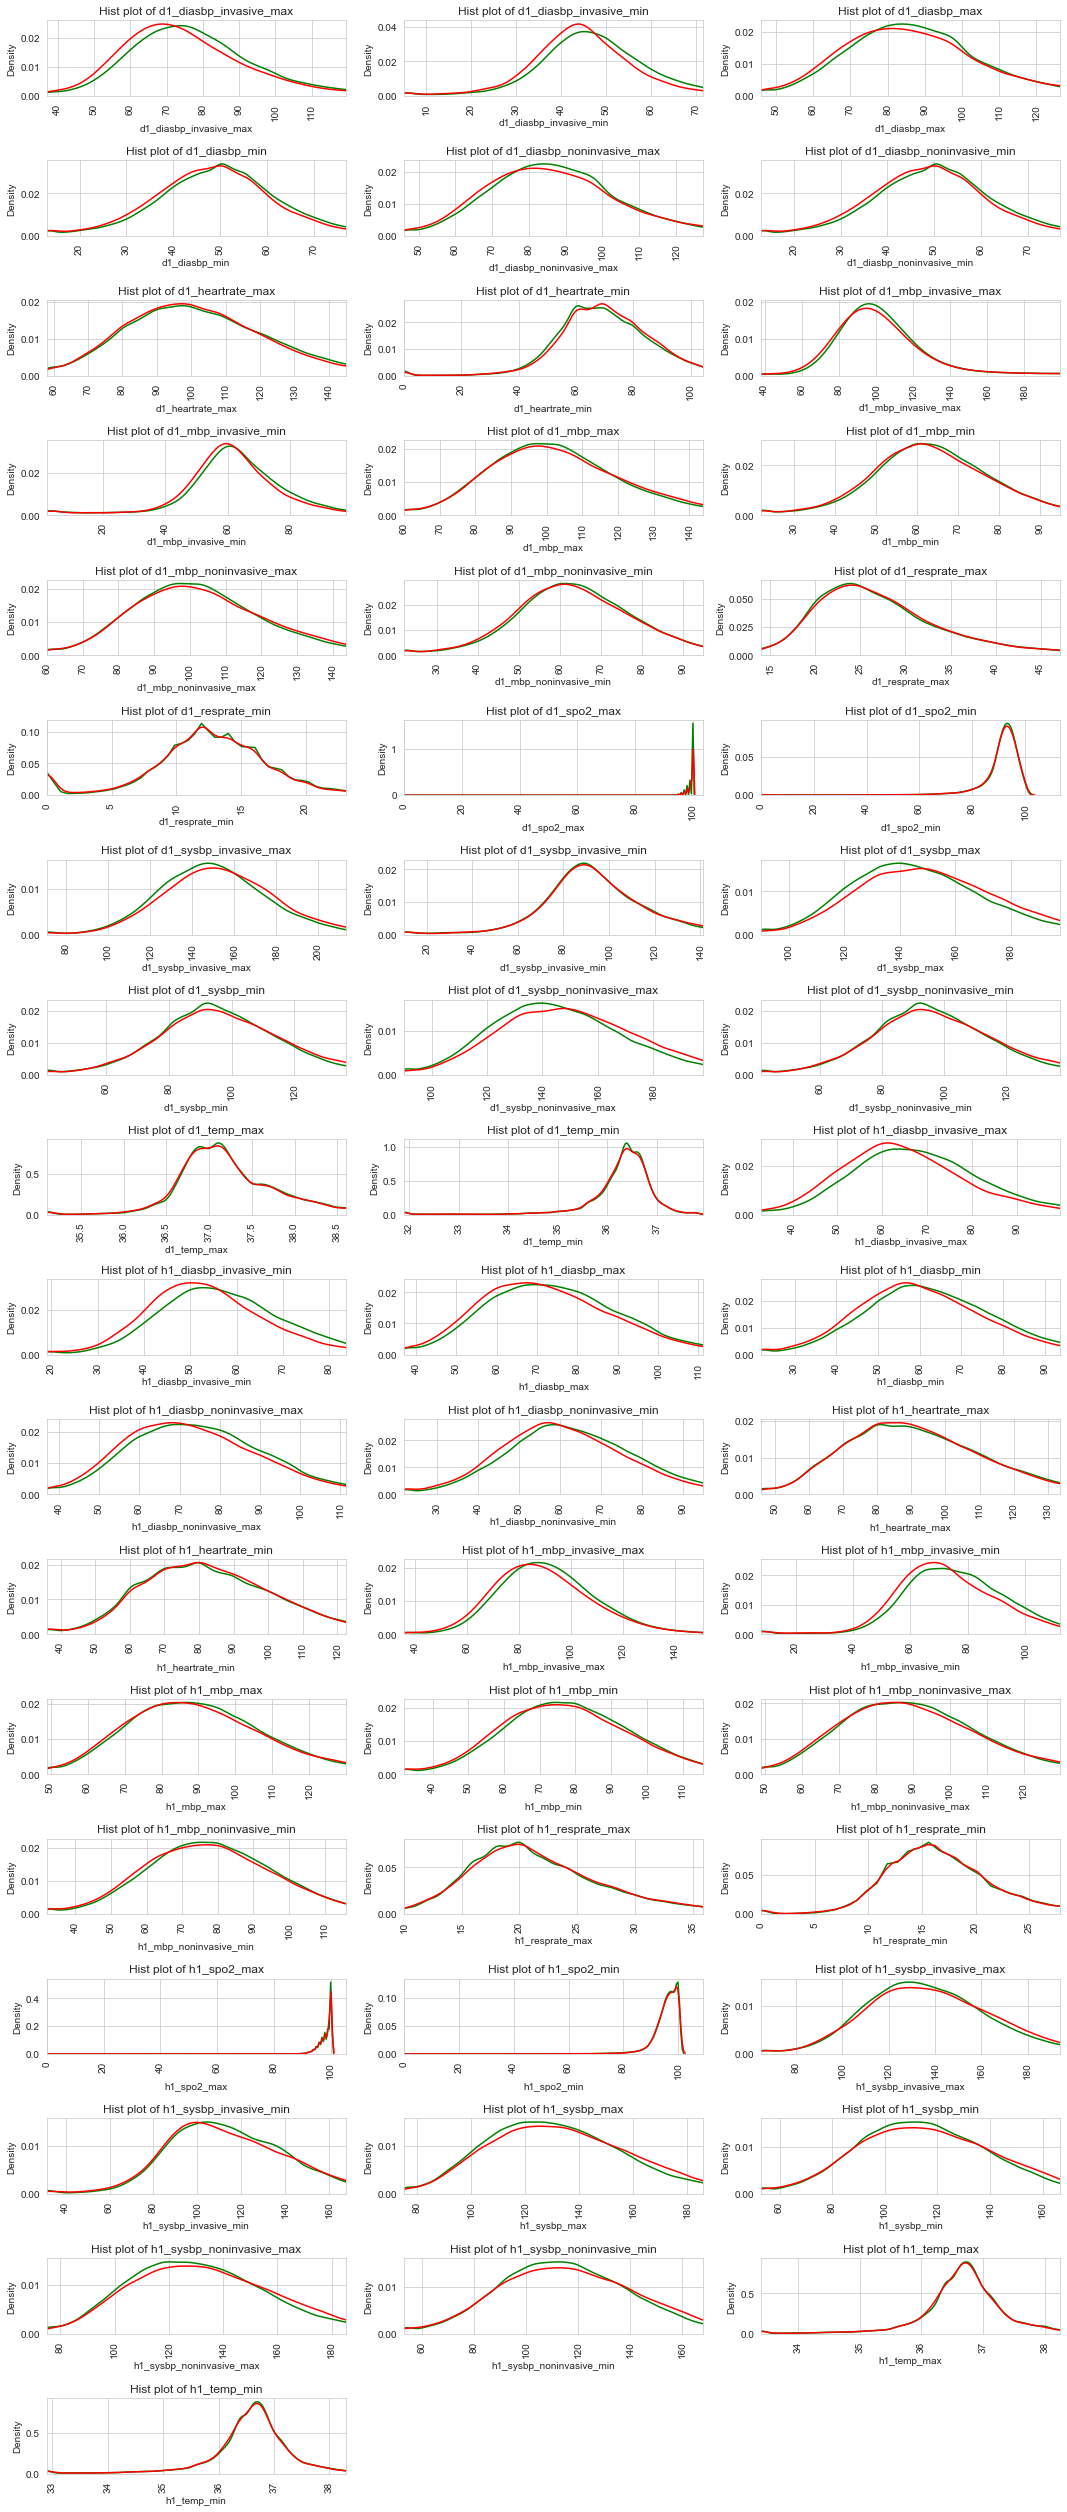

In [75]:
%%time
plt.figure(figsize=(15,35))
vars_to_look = vitals_features
for i, var in enumerate(vars_to_look):
    plt.subplot(18,3,i+1)
    plt.xticks(rotation = 90)
    #sns.histplot(x=var, data=diabetes,stat="density",hue="diabetes_mellitus")
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==0],color="green");
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==1],color="red");
    plt.xlim(limits_dict[var]["min"],limits_dict[var]["max"])
    plt.title("Hist plot of " + var)
plt.tight_layout()

Observations : 
* It is True that in invasive ways used to measure physiological variables are more accurate, but due too many missing and since there are noninvasive measurements probably will be more handy to drop invasive features
* h1_spo2_max,h1_spo2_min,h1_resprate_min there are patients with 0 as min value... thats suspicious 

## labs

In [76]:
data_info[data_info["Category"]=="labs"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
97,labs,d1_albumin_max,None,numeric,The lowest albumin concentration of the patien...,30
98,labs,d1_albumin_min,g/L,numeric,The lowest albumin concentration of the patien...,30
99,labs,d1_bilirubin_max,micromol/L,numeric,The highest bilirubin concentration of the pat...,20
100,labs,d1_bilirubin_min,micromol/L,numeric,The lowest bilirubin concentration of the pati...,20
101,labs,d1_bun_max,mmol/L,numeric,The highest blood urea nitrogen concentration ...,5
102,labs,d1_bun_min,mmol/L,numeric,The lowest blood urea nitrogen concentration o...,5
103,labs,d1_calcium_max,mmol/L,numeric,The highest calcium concentration of the patie...,2.5
104,labs,d1_calcium_min,mmol/L,numeric,The lowest calcium concentration of the patien...,2.5
105,labs,d1_creatinine_max,micromol/L,numeric,The highest creatinine concentration of the pa...,70
106,labs,d1_creatinine_min,micromol/L,numeric,The lowest creatinine concentration of the pat...,70


In [77]:
labs_features =  data_info[data_info["Category"]=="labs"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()

In [78]:
diabetes[labs_features].isnull().mean().sort_values(ascending=False)

h1_bilirubin_max     0.920896
h1_bilirubin_min     0.920896
h1_albumin_max       0.914319
h1_albumin_min       0.914319
h1_lactate_min       0.910185
h1_lactate_max       0.910185
h1_hco3_min          0.817436
h1_hco3_max          0.817436
h1_wbc_min           0.814294
h1_wbc_max           0.814294
h1_calcium_max       0.813794
h1_calcium_min       0.813794
h1_platelets_min     0.812319
h1_platelets_max     0.812319
h1_bun_min           0.806641
h1_bun_max           0.806641
h1_creatinine_min    0.805059
h1_creatinine_max    0.805059
h1_hematocrit_min    0.791014
h1_hematocrit_max    0.791014
h1_hemaglobin_max    0.789739
h1_hemaglobin_min    0.789739
h1_sodium_max        0.781986
h1_sodium_min        0.781986
h1_potassium_max     0.774611
h1_potassium_min     0.774611
d1_lactate_max       0.733752
d1_lactate_min       0.733752
h1_inr_max           0.623962
h1_inr_min           0.623962
d1_inr_max           0.623962
d1_inr_min           0.623962
d1_bilirubin_max     0.589557
d1_bilirub

In [79]:
diabetes[labs_features].describe()

,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min
count,58751.000000,58751.000000,53422.000000,53422.000000,116423.000000,116423.000000,113465.000000,113465.000000,116884.000000,116884.000000,121914.000000,121914.000000,110110.000000,110110.000000,113925.000000,113925.000000,114569.000000,114569.000000,48944.000000,48944.000000,34654.000000,34654.000000,111600.000000,111600.000000,117611.000000,117611.000000,116887.000000,116887.000000,112728.000000,112728.000000,11152.000000,11152.000000,10296.000000,10296.000000,25167.000000,25167.000000,24236.000000,24236.000000,25373.000000,25373.000000,55084.000000,55084.000000,23762.000000,23762.000000,27367.000000,27367.000000,27201.000000,27201.000000,48944.000000,48944.000000,11690.000000,11690.000000,24428.000000,24428.000000,29336.000000,29336.000000,28376.000000,28376.000000,24171.000000,24171.000000
mean,2.952673,2.883073,1.191379,1.117405,25.578808,23.554154,8.379782,8.164674,1.493531,1.363795,174.149802,114.440310,24.452872,23.192344,11.459810,10.901491,34.555834,32.939299,1.577788,1.463473,2.922075,2.078145,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,3.008563,3.007254,1.187979,1.187173,25.631220,25.606374,8.274175,8.265049,1.526582,1.524339,167.702625,158.908794,22.544112,22.486146,11.204166,11.088205,33.731830,33.349796,1.577788,1.463473,3.028198,2.976982,193.943057,193.123506,4.188984,4.147028,138.167205,137.879814,13.387873,13.336485
std,0.675606,0.679808,2.319165,2.201525,20.495927,18.708332,0.740098,0.793055,1.525906,1.341642,86.545466,38.217682,4.364990,5.000293,2.149213,2.338048,6.194616,6.806350,0.946477,0.737639,3.057443,2.064291,89.547477,88.121757,0.666942,0.579459,4.827752,4.926242,6.782836,5.924633,0.738170,0.738457,2.375772,2.375223,21.377589,21.360676,0.892787,0.905489,1.572771,1.570070,94.033461,88.298827,5.138495,5.144693,2.350633,2.381224,6.804903,6.963975,0.946477,0.737639,2.898524,2.854953,92.486473,92.692759,0.760183,0.749463,5.711628,5.658036,6.933161,6.915142
min,1.200000,1.100000,0.200000,0.200000,4.000000,3.000000,6.200000,5.500000,0.340000,0.300000,73.000000,33.000000,12.000000,7.000000,6.800000,5.300000,20.400000,16.100000,0.900000,0.900000,0.400000,0.400000,27.000000,18.550000,2.800000,2.400000,123.000000,117.000000,1.200000,0.900000,1.100000,1.100000,0.200000,0.200000,4.000000,4.000000,5.600000,5.300000,0.330000,0.330000,59.000000,42.000000,6.000000,6.000000,5.100000,5.000000,16.000000,15.500000,0.900000,0.900000,0.400000,0.400000,20.000000,20.000000,2.500000,2.500000,114.000000,114.000000,1.100000,1.089800
25%,2.500000,2.400000,0.400000,0.400000,13.000000,12.000000,7.900000,7.700000,0.750000,0.710000,117.000000,91.000000,22.000000,21.000000,9.900000,9.200000,30.000000,28.000000,1.100000,1.100000,1.200000,1.000000,147.000000,136.000000,3.800000,3.600000,137.000000,135.000000,8.000000,7.400000,2.500000,2.500000,0.400000,0.400000,13.000000,13.000000,7.700000,7.700000,0.780000,0.780000,111.000000,106.000000,20.000000,20.000000,9.600000,9.400000,29.000000,28.400000,1.100000,1.100000,1.300000,1.250000,131.000000,130.000000,3.700000,3.700000,136.000000,135.000000,8.600000,8.500000
50%,3.

Wall time: 29 s


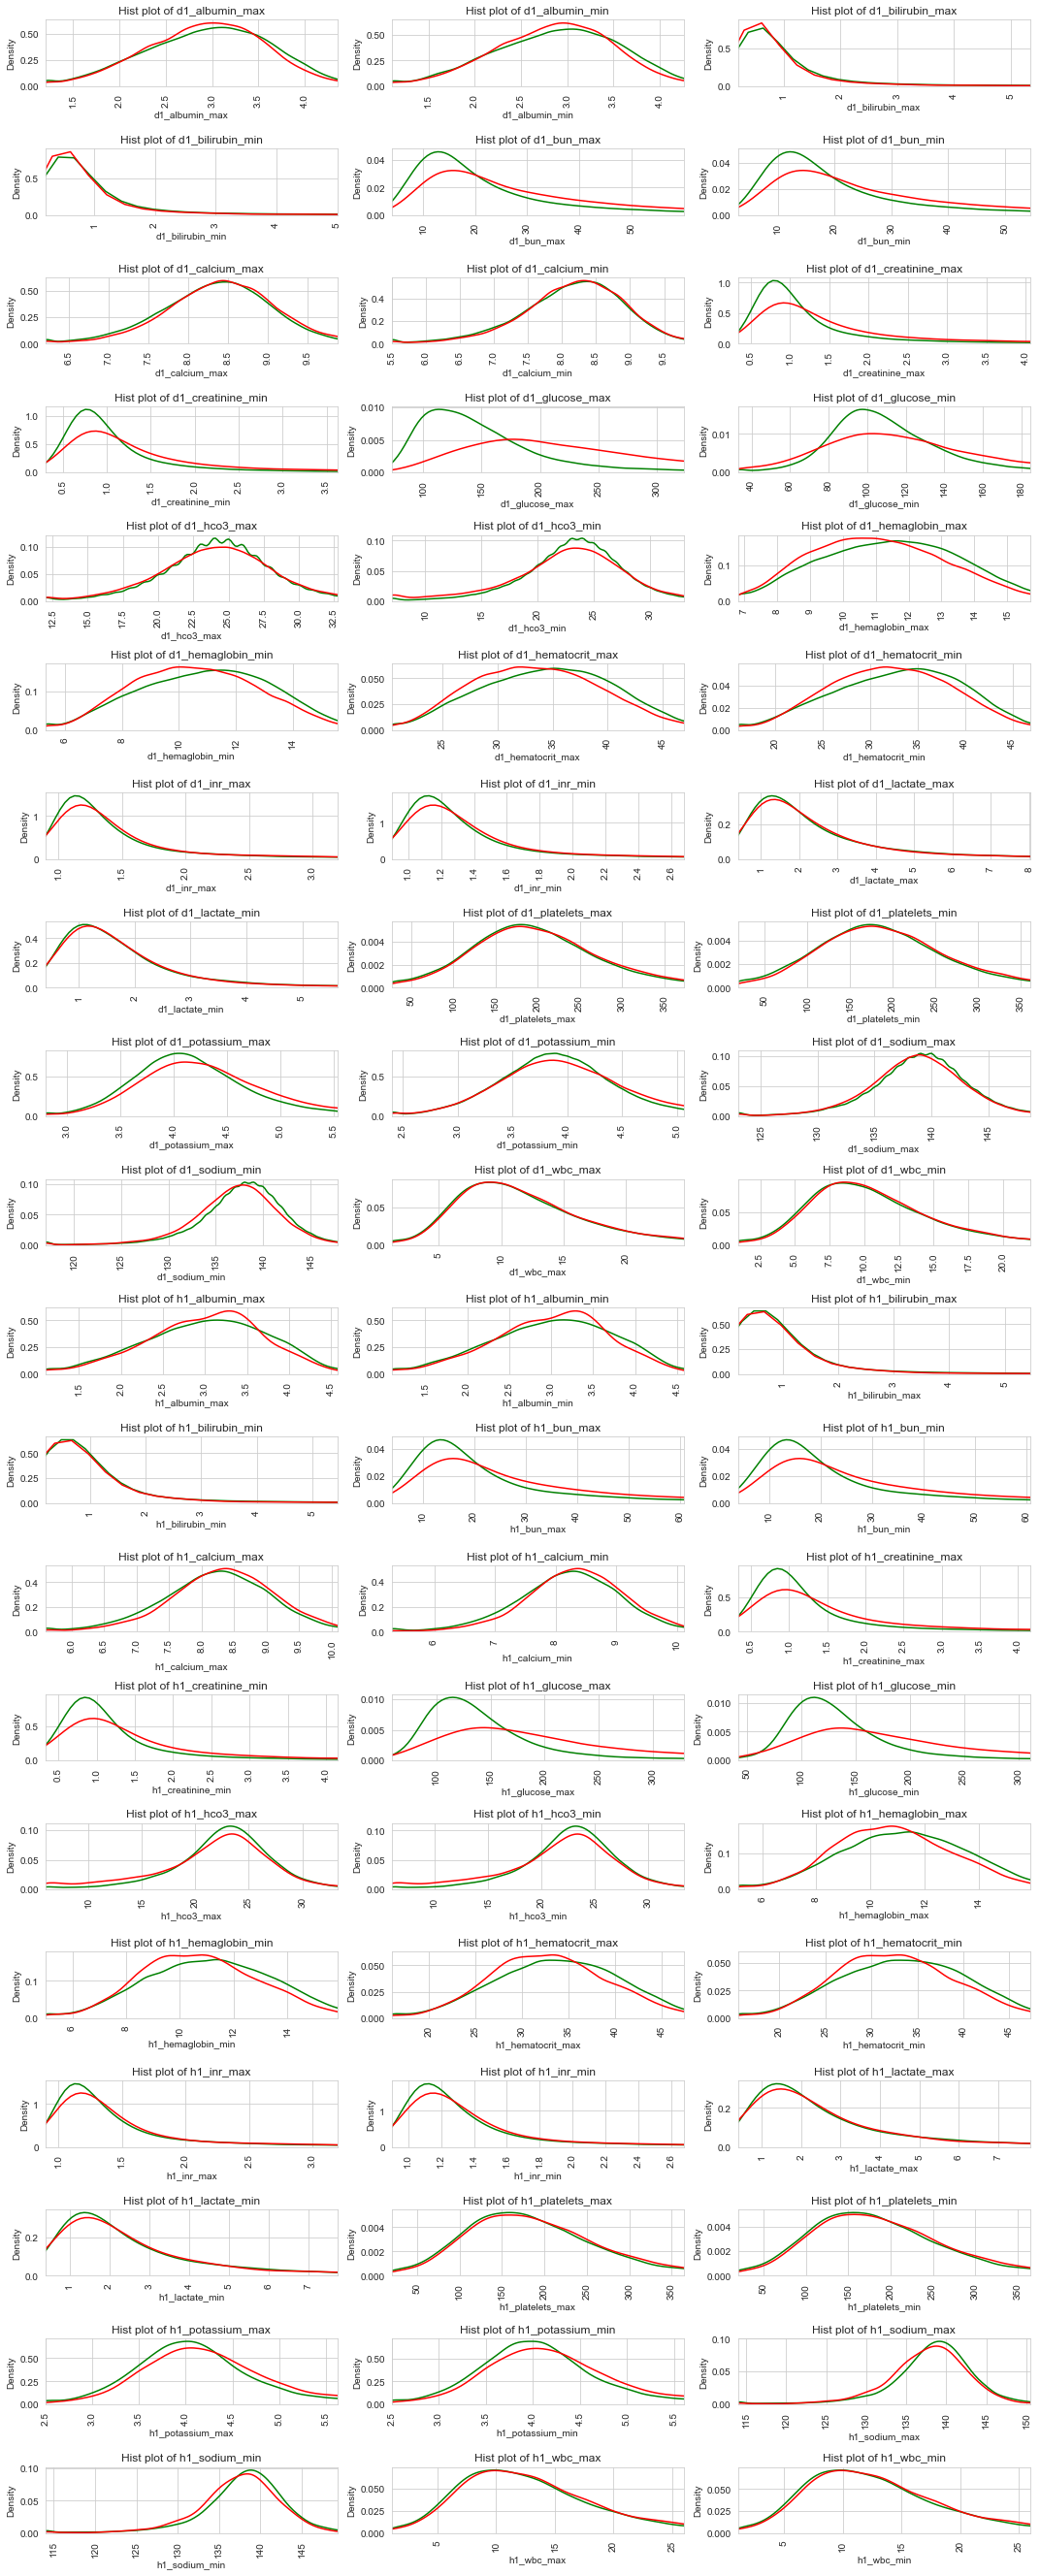

In [80]:
%%time
plt.figure(figsize=(15,37))
vars_to_look = labs_features
for i, var in enumerate(vars_to_look):
    plt.subplot(20,3,i+1)
    plt.xticks(rotation = 90)
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==0],color="green");
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==1],color="red");
    plt.xlim(limits_dict[var]["min"],limits_dict[var]["max"])
    plt.title("Hist plot of " + var)
plt.tight_layout()

## labs blood gas

In [81]:
data_info[data_info["Category"]=="labs blood gas"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
157,labs blood gas,d1_arterial_pco2_max,Millimetres of mercury,numeric,The highest arterial partial pressure of carbo...,40
158,labs blood gas,d1_arterial_pco2_min,Millimetres of mercury,numeric,The lowest arterial partial pressure of carbon...,40
159,labs blood gas,d1_arterial_ph_max,None,numeric,The highest arterial pH for the patient during...,7.4
160,labs blood gas,d1_arterial_ph_min,None,numeric,The lowest arterial pH for the patient during ...,7.4
161,labs blood gas,d1_arterial_po2_max,Millimetres of mercury,numeric,The highest arterial partial pressure of oxyge...,80
162,labs blood gas,d1_arterial_po2_min,Millimetres of mercury,numeric,The lowest arterial partial pressure of oxygen...,80
163,labs blood gas,d1_pao2fio2ratio_max,Fraction,numeric,The highest fraction of inspired oxygen for th...,0.21
164,labs blood gas,d1_pao2fio2ratio_min,Fraction,numeric,The lowest fraction of inspired oxygen for the...,0.21
165,labs blood gas,h1_arterial_pco2_max,Millimetres of mercury,numeric,The highest arterial partial pressure of carbo...,40
166,labs blood gas,h1_arterial_pco2_min,Millimetres of mercury,numeric,The lowest arterial partial pressure of carbon...,40


In [82]:
labs_bloodgas_features =  data_info[data_info["Category"]=="labs blood gas"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()

In [83]:
diabetes[labs_bloodgas_features].isnull().mean().sort_values(ascending=False)

h1_pao2fio2ratio_min    0.871232
h1_pao2fio2ratio_max    0.871232
h1_arterial_ph_min      0.828607
h1_arterial_ph_max      0.828607
h1_arterial_pco2_min    0.827201
h1_arterial_pco2_max    0.827201
h1_arterial_po2_min     0.825503
h1_arterial_po2_max     0.825503
d1_pao2fio2ratio_min    0.717126
d1_pao2fio2ratio_max    0.717126
d1_arterial_ph_min      0.651575
d1_arterial_ph_max      0.651575
d1_arterial_pco2_min    0.648916
d1_arterial_pco2_max    0.648916
d1_arterial_po2_min     0.645451
d1_arterial_po2_max     0.645451
dtype: float64

In [84]:
diabetes[labs_bloodgas_features].describe()

,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
count,45696.000000,45696.000000,45350.000000,45350.000000,46147.000000,46147.000000,36818.000000,36818.000000,22491.000000,22491.000000,22308.000000,22308.000000,22712.000000,22712.000000,16760.000000,16760.000000
mean,45.341451,38.535587,7.387687,7.322903,165.003814,102.957476,287.600071,224.005403,44.552966,43.341081,7.337283,7.327771,163.035835,145.949537,247.525419,239.617358
std,14.623775,10.996254,0.085651,0.111530,107.084058,61.514357,130.319620,119.119675,14.631359,14.052015,0.105930,0.108658,112.646743,100.211935,131.440167,128.562211
min,18.400000,14.900000,7.054280,6.890000,39.000000,28.000000,54.800000,36.000000,15.000000,14.997000,6.930000,6.900000,34.000000,31.000000,42.000000,38.000000
25%,36.200000,32.000000,7.340000,7.270000,88.000000,68.000000,192.205556,132.000000,36.000000,35.000000,7.290000,7.280000,80.000000,77.000000,144.000000,138.000000
50%,42.900000,37.000000,7.390000,7.340000,127.000000,85.000000,275.000000,205.000000,42.000000,41.000000,7.350000,7.340000,119.900000,108.000000,228.125000,218.750000
75%,50.000000,43.000000,7.440000,7.398000,206.000000,116.250000,370.000000,300.000000,49.000000,48.000000,7.408000,7.400000,214.000000,182.000000,333.000000,324.000000
max,111.000000,85.912000,7.620000,7.557860,540.865000,448.892000,834.805000,604.227778,111.505000,107.000000,7.570000,7.563000,534.905000,514.905000,720.000000,654.813793


Wall time: 5.47 s


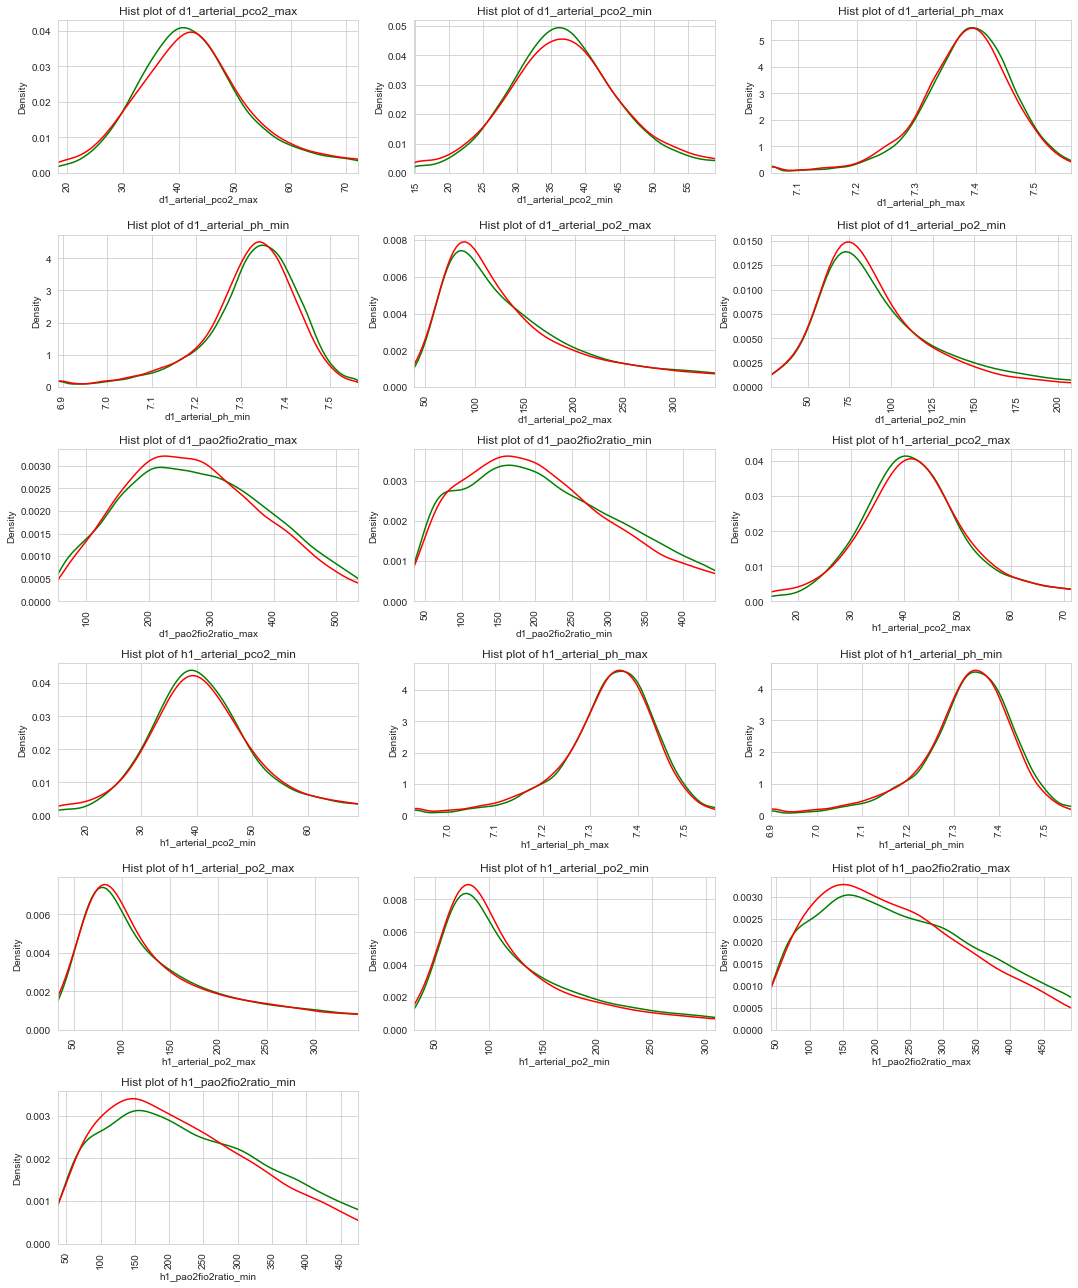

In [85]:
%%time
plt.figure(figsize=(15,18))
vars_to_look = labs_bloodgas_features
for i, var in enumerate(vars_to_look):
    plt.subplot(6,3,i+1)
    plt.xticks(rotation = 90)
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==0],color="green");
    sns.kdeplot(x=var, data=diabetes[diabetes["diabetes_mellitus"]==1],color="red");
    plt.xlim(limits_dict[var]["min"],limits_dict[var]["max"])
    plt.title("Hist plot of " + var)
plt.tight_layout()

# EDA TEST

In [87]:
test = pd.read_csv("../data/raw/UnlabeledWiDS2021.csv")

In [88]:
diabetes[diabetes.hospital_id.isin(test.hospital_id.unique())]

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


None of the Hospitals in test ID  are from the ones in train.. so hospital_id should be drop. 

## Compare With Train

### Numeric

In [89]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables 
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

Interpretation
* PSI < 0.1: no significant population change
* PSI < 0.2: moderate population change
* PSI >= 0.2: significant population change

In [90]:
psi_numeric_dict = {}
vars_to_look = data_info[data_info["Data Type"]=="numeric"]["Variable Name"].tolist()
vars_to_look.append("bmi")
for var in vars_to_look:
    psi_numeric_dict[var]=calculate_psi(diabetes[var].values, test[var].values, buckettype='quantiles', buckets=10, axis=1)
psi_numeric=pd.DataFrame((pd.Series(psi_numeric_dict).sort_values(ascending=False)),columns=["psi"])

In [91]:
psi_numeric.round(3)

,psi
age,0.227
weight,0.075
bmi,0.068
pre_icu_los_days,0.013
h1_heartrate_min,0.012
...,...
d1_hematocrit_max,0.000
d1_hematocrit_min,0.000
h1_albumin_max,0.000
h1_albumin_min,0.000


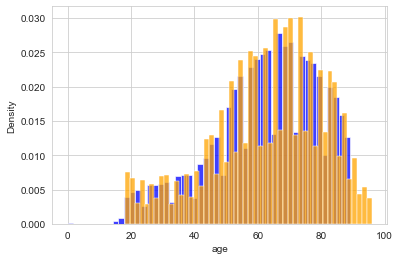

In [92]:
sns.histplot(data=diabetes,x="age",bins=50,stat="density",color="blue")
sns.histplot(data=test,x="age",bins=50,stat="density",color="orange");

In [93]:
diabetes["age"].describe(percentiles=np.arange(0,1,0.1))

count    125169.000000
mean         61.995103
std          16.822880
min           0.000000
0%            0.000000
10%          37.000000
20%          49.000000
30%          55.000000
40%          60.000000
50%          64.000000
60%          68.000000
70%          73.000000
80%          77.000000
90%          83.000000
max          89.000000
Name: age, dtype: float64

In [94]:
test["age"].describe(percentiles=np.arange(0,1,0.1))

count    10234.000000
mean        62.853625
std         17.851661
min         18.000000
0%          18.000000
10%         37.000000
20%         49.000000
30%         55.000000
40%         60.000000
50%         65.000000
60%         70.000000
70%         74.000000
80%         79.000000
90%         85.000000
max         96.000000
Name: age, dtype: float64

Observations

People with age lower to 18 Years must be drop.. It is supposed to be a clinical study for Young Adults... No minor should be in the dataset

It also looks like there are older people in the UnLabeled dataset. 

### Binary

In [95]:
vars_to_look = data_info[data_info["Data Type"]=="binary"]["Variable Name"].tolist()
vars_to_look.remove("diabetes_mellitus")

In [96]:
df1=diabetes[vars_to_look].apply(lambda x:x.value_counts()).T
df2=test[vars_to_look].apply(lambda x:x.value_counts()).T
display_side_by_side(df1/len(diabetes),df2/len(test))

,0.0,1.0
elective_surgery,0.810160,0.189840
readmission_status,1.000000,NaN
apache_post_operative,0.792889,0.207111
arf_apache,0.972003,0.027997
gcs_unable_apache,0.983174,0.011379
intubated_apache,0.843374,0.156626
ventilated_apache,0.669568,0.330432
aids,0.998970,0.001030
cirrhosis,0.983919,0.016081
hepatic_failure,0.986401,0.013599


### String

In [97]:
vars_to_look = data_info[data_info["Data Type"]=="string"]["Variable Name"].tolist()
vars_to_look.remove("bmi")
vars_to_look

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_admit_type',
 'icu_stay_type',
 'icu_type',
 'apache_2_diagnosis',
 'apache_3j_diagnosis']

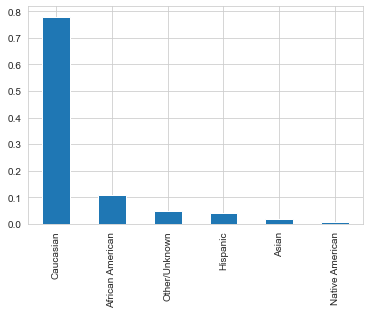

Wall time: 291 ms


<Figure size 1080x1296 with 0 Axes>

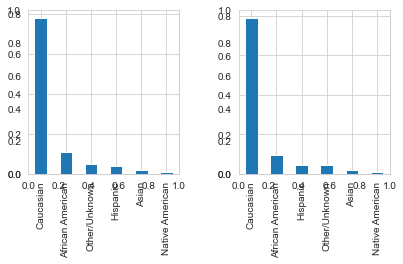

In [122]:
%%time
plt.figure(figsize=(15,18))
vars_to_look = ["ethnicity"]
fig, axs = plt.subplots(1, 2)
for i, var in enumerate(vars_to_look):
    ax1 = fig.add_subplot(121)
    diabetes["ethnicity"].value_counts(1).plot(kind="bar",ax=ax1);
    ax2 = fig.add_subplot(122)
    test["ethnicity"].value_counts(1).plot(kind="bar",ax=ax2);
    plt.tight_layout();
plt.tight_layout();